In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr


In [2]:
# Load the reference (pharmgkb) and the sg10k dataset
pgkb_df = pd.read_csv('/home/jupyter-yusuf/Consensus/data_viz/References/PharmGKB.csv')
haplotype_df = pd.read_parquet('/home/jupyter-yusuf/Consensus/output/3_haplotypes.parquet')

In [3]:
# Data cleaning
haplotype_df = haplotype_df.rename(columns={'AF': 'SG10K', 'AF_GA_C': 'Chinese', 'AF_GA_I': 'Indian', 'AF_GA_M': 'Malay'})

In [4]:
# Data cleaning
pgkb_df = pgkb_df.fillna(0)
pgkb_df.iloc[:,1:] = pgkb_df.iloc[:,1:].applymap(lambda x: x*100)
pgkb_df = pgkb_df.drop(pgkb_df.columns[[1,6,7,8]], axis=1).copy()
pgkb_df.columns = ["haplotype","American","Central/South Asian","East Asian", "European","African"]

In [5]:
sp_df = pd.merge(haplotype_df, pgkb_df, on = 'haplotype', how = 'left')
sp_df.head()


,haplotype,AC,SG10K,AC_C,AF_C,Chinese,AC_I,AF_I,Indian,AC_M,AF_M,Malay,activity_value,function,American,Central/South Asian,East Asian,European,African
0,*10+*36,861,28.950908,771.0,25.924681,34.297153,10.0,0.336247,3.048780,80.0,2.689980,20.100503,0.25,Decreased function,0.14,1.23,34.13,0.00,0.08
1,*1,827,27.807666,581.0,19.535978,25.845196,124.0,4.169469,37.804878,122.0,4.102219,30.653266,1.00,Normal function,51.11,28.71,24.53,28.28,7.79
2,*10,519,17.451244,405.0,13.618023,18.016014,11.0,0.369872,3.353659,103.0,3.463349,25.879397,0.25,Decreased function,1.44,8.67,43.56,1.57,5.57
3,*2,295,9.919301,193.0,6.489576,8.585409,64.0,2.151984,19.512195,38.0,1.277740,9.547739,1.00,Normal function,22.08,29.48,12.05,18.56,19.83
4,*41,141,4.741089,84.0,2.824479,3.736655,40.0,1.344990,12.195122,17.0,0.571621,4.271357,0.50,Decreased function,2.33,12.30,2.27,9.24,11.47


In [6]:
pairs = [('SG10K', 'East Asian'), ('Chinese', 'East Asian'), ('Malay', 'East Asian'), ('Indian', 'Central/South Asian')]

for pair in pairs:
    diff_col_name = 'diff_' + pair[0]
    diff = sp_df[pair[0]] - sp_df[pair[1]]
    zscore_col_name = 'zscore_' + diff_col_name
    zscore = np.abs((diff - diff.mean()) / diff.std())
    value = zscore.apply(lambda x: '<3' if x <= 3.0 else '>3')
    sp_df[zscore_col_name] = value
    

# Print the modified DataFrame
filtered_df = sp_df.loc[(sp_df.filter(like='zscore_') == '>3').any(axis=1)]
filtered_df

,haplotype,AC,SG10K,AC_C,AF_C,Chinese,AC_I,AF_I,Indian,AC_M,...,function,American,Central/South Asian,East Asian,European,African,zscore_diff_SG10K,zscore_diff_Chinese,zscore_diff_Malay,zscore_diff_Indian
0,*10+*36,861,28.950908,771.0,25.924681,34.297153,10.0,0.336247,3.048780,80.0,...,Decreased function,0.14,1.23,34.13,0.00,0.08,<3,<3,>3,<3
1,*1,827,27.807666,581.0,19.535978,25.845196,124.0,4.169469,37.804878,122.0,...,Normal function,51.11,28.71,24.53,28.28,7.79,<3,<3,<3,>3
2,*10,519,17.451244,405.0,13.618023,18.016014,11.0,0.369872,3.353659,103.0,...,Decreased function,1.44,8.67,43.56,1.57,5.57,>3,>3,>3,<3
3,*2,295,9.919301,193.0,6.489576,8.585409,64.0,2.151984,19.512195,38.0,...,Normal function,22.08,29.48,12.05,18.56,19.83,<3,<3,<3,>3
33,*4+*4,1,0.033625,0.0,0.000000,0.000000,1.0,0.033625,0.304878,0.0,...,No function,NaN,NaN,NaN,NaN,NaN,>3,>3,>3,>3


# Heatmap correlation PharmGKB and SG10k

Text(0.5, 1.0, 'Heatmap Correlation of Haplotype Frequency from PharmGKB and SG10K')

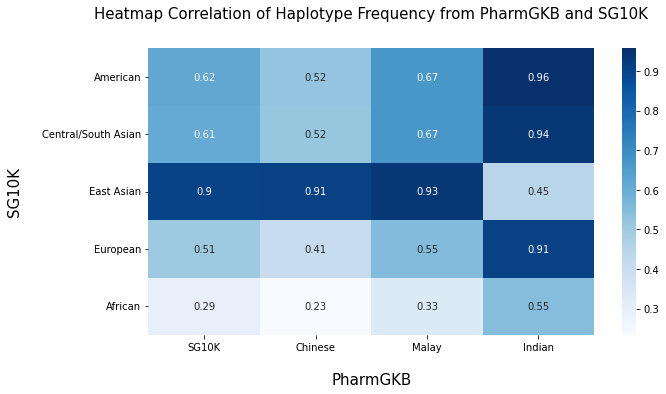

In [7]:
sp_corr = sp_df[['SG10K', 'Chinese', 'Malay', 'Indian', 'American', 'Central/South Asian', 'East Asian', 'European', 'African']].corr()

sp_corr = sp_corr.iloc[4:,0:4]
# sp_corr
plt.figure(figsize = (10,5))
chart = sns.heatmap(sp_corr, annot=True, cmap = 'Blues')
plt.xlabel('PharmGKB', fontsize = 15, labelpad = 20)
plt.ylabel('SG10K', fontsize = 15, labelpad= 20)
plt.tight_layout()
plt.title('Heatmap Correlation of Haplotype Frequency from PharmGKB and SG10K', fontsize = 15, pad = 30)


## Scatter plot

In [10]:


def sp_pharmgkb(x, y, hue, data, ax, palette, title, xlabel):
    data = data.copy()  
    data[x] = data[x]/100  # divide by 100 to get frequency
    data[y] = data[y]/100  
    sns.scatterplot(ax=ax, x=x, y=y, data=data, hue=hue, legend=None, palette=palette, color = 'black')
    ax.grid(alpha=.3)
    data_cleaned = data.replace([np.inf, -np.inf], np.nan).dropna()

    corr_coef, p_value = pearsonr(data_cleaned[x], data_cleaned[y])

    ax.text(0.3, 0.1, f'r = {corr_coef:.3f}\np = {p_value:.3g}')
    ax.plot([0, 1], [0, 1], linewidth=2, alpha=.2, color = 'black')
    ax.set(ylim=(0, 0.5), xlim=(0, 0.5))
    ax.set_title(title, fontdict=None, loc='center', pad=None, weight='semibold')
    ax.set_xlabel(xlabel, weight='semibold')
    ax.set_ylabel(ylabel=y, weight='semibold')

    # temporary modify data[hue][line] == '1'
    for line in range(0, data.shape[0]):
        if data[hue][line] == '>3':
            ax.text(data[x][line] + 0.02, data[y][line], data['haplotype'][line], horizontalalignment='left', size='small', color='black')

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


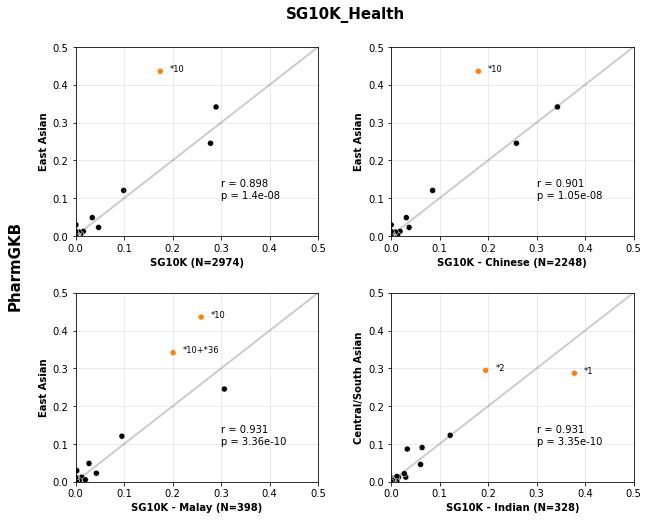

In [12]:
fig, axes = plt.subplots(2, 2, sharex=False, sharey=False, figsize=(10, 8))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3)

sp_pharmgkb(x='SG10K', y='East Asian', data=sp_df, ax=axes[0, 0], hue='zscore_diff_SG10K', palette=["black", "C1"], xlabel=f"SG10K (N={sp_df['AC'].sum()})", title = None)

sp_pharmgkb(x='Chinese', y='East Asian', data=sp_df, ax=axes[0, 1], hue='zscore_diff_Chinese', palette=["black", "C1"], xlabel=f'SG10K - Chinese (N={int(sp_df["AC_C"].sum())})', title = None)

sp_pharmgkb(x='Malay', y='East Asian', data=sp_df, ax=axes[1, 0], hue='zscore_diff_Malay', palette=["C1", "black"], xlabel=f'SG10K - Malay (N={int(sp_df["AC_M"].sum())})', title = None)

sp_pharmgkb(x='Indian', y='Central/South Asian', data=sp_df, ax=axes[1, 1], hue='zscore_diff_Indian', palette=["black", "C1"], xlabel=f'SG10K - Indian (N={int(sp_df["AC_I"].sum())})',title = None)

fig.text(0.03, 0.5, 'PharmGKB', va='center', rotation='vertical', fontsize=15, weight='semibold')
fig.suptitle('SG10K_Health', x=0.5, y=0.95, horizontalalignment='center', fontsize=15, weight='semibold')

plt.show()


TypeError: sp_pharmgkb() missing 1 required positional argument: 'xlabel'

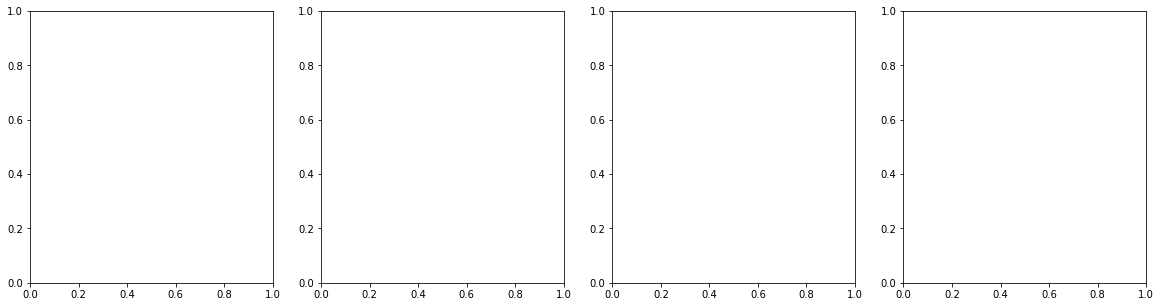

In [13]:
fig, axes = plt.subplots(1, 4, sharex=False, sharey = False,figsize=(20,5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)



sp_pharmgkb(x = 'SG10K',y = 'East Asian', data = sp_df, ax = axes[0], hue = 'zscore_diff_SG10K', palette=["C0", "C1"], title = f"SG10K\n N = {sp_df['AC'].sum()}")
sp_pharmgkb(x = 'Chinese',y = 'East Asian', data = sp_df, ax = axes[1], hue = 'zscore_diff_Chinese', palette=["C0", "C1"], title = f'SG10K - Chinese\n N = {int(sp_df["AC_C"].sum())}')
sp_pharmgkb(x = 'Malay',y = 'East Asian', data = sp_df, ax = axes[2], hue = 'zscore_diff_Malay', palette=["C1", "C0"], title = f'SG10K - Malay\n N = {int(sp_df["AC_M"].sum())}')
sp_pharmgkb(x = 'Indian',y = 'Central/South Asian', data = sp_df, ax = axes[3], hue = 'zscore_diff_Indian', palette=["C0", "C1"], title = f'SG10K - Indian\n N = {int(sp_df["AC_I"].sum())}')